In [1]:
!pip install pate

  Using cached numpy-1.24.4-cp311-cp311-win_amd64.whl.metadata (5.6 kB)
Using cached numpy-1.24.4-cp311-cp311-win_amd64.whl (14.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4


  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
miceforest 6.0.3 requires pandas>=2.1.0, but you have pandas 2.0.3 which is incompatible.
pyfume 0.3.4 requires pandas==1.5.3, but you have pandas 2.0.3 which is incompatible.
pygam 0.9.1 requires numpy>=1.25; python_version >= "3.9" and python_version < "3.13", but you have numpy 1.24.4 which is incompatible.
pygam 0.9.1 requires scipy<1.12,>=1.11.1; python_version >= "3.9" and python_version < "3.13", but you have scipy 1.10.1 which is incompatible.
streamlit 1.30.0 requires packaging<24,>=16.8, but you have packaging 24.0 which is incompatible.
tensorflow-intel 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.4 which is incompatible.


In [2]:
import pandas as pd
import glob
import os
from pate.PATE_metric import PATE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

gt = "../data/ground-truth/"
results = "../data/model-results/"

In [10]:
# HotSax results are stored in a different format. We need to convert them to the same format as the other models
hot_sax = "../data/model-results/hotsax/"

for file in glob.glob(hot_sax + "/*.csv"):
    df = pd.read_csv(file)
    df = df.T
    df = sorted(df.values.tolist(), key=lambda x: x[0])
    df = pd.DataFrame(df, index=None)
    if (sum(df[0].values) == 0):
        print("HotSAX: ConversionError? No anomalies detected in", file)
    print("Converting",  len(df), "anomalies in", file)
    df.to_csv(file.title(), index=False, header=False)

Converting 35000 anomalies in ../data/model-results/hotsax\X_cca.csv
Converting 1000 anomalies in ../data/model-results/hotsax\X_dn.csv
Converting 35000 anomalies in ../data/model-results/hotsax\X_fca.csv
Converting 35000 anomalies in ../data/model-results/hotsax\X_ma.csv
Converting 35000 anomalies in ../data/model-results/hotsax\X_mca.csv
Converting 35000 anomalies in ../data/model-results/hotsax\X_sa.csv
Converting 1000 anomalies in ../data/model-results/hotsax\X_sbma.csv
Converting 35000 anomalies in ../data/model-results/hotsax\X_zero_block.csv


In [11]:
def get_results_from_model(model_name, idx, results_folder):
    files = glob.glob(results_folder + model_name + "/*.csv")
    try:
        if len(files) == 0:
            print(model_name+ ": Results not found- please run the model on the test data first")
            return None
        if len(files) < idx:
            print("File not found")
        return pd.read_csv(files[idx], header=None)
    except:
        print("Error in reading file")
        return None



def get_pate_score(gt, results):
    pate = PATE(gt[0], results[0], binary_scores=False)
    pate1= PATE(gt[0], results[0], binary_scores=True)
    return pate, pate1


def evaluate(results_folder, gt_folder):
    results_eval = []
    for index, file in enumerate(glob.glob(gt_folder + '/*.csv')):
        gt = pd.read_csv(file, header=None)
        pate_scores = []
        print("Evaluating", file)
        for model in os.listdir(results_folder):
            results = get_results_from_model(model, index, results_folder)
            if results is None:
                continue
            pate, pate1 = get_pate_score(gt, results)
            print(model, pate, pate1)
            pate_scores.append([model, pate, pate1])
        for score in pate_scores:
            results_eval.append([file, score[0], score[1], score[2]])
    results_df = pd.DataFrame(results_eval, columns=["Testcase", "Model", "PATE", "PATE_F1"])
    return results_df

In [12]:
df = evaluate(results, gt)

Evaluating ../data/ground-truth\gt_cca.csv
baseline-anomal 0.5645354410157235 0.22863185340309428
baseline-kan 0.4831229109415687 0.4294450647096385
hotsax 0.06453544101572352 0.0
isolation-forest 0.2088665800238283 0.030068265670678804
knn 0.377119859688501 0.16422706915962731
lstm-ae 0.6656282003164744 0.4840406607770579
statistical 0.3181826644932588 0.22863185340309428
Evaluating ../data/ground-truth\gt_dn.csv
baseline-anomal 0.6360244988864143 0.427497256560452
baseline-kan 0.6360244988864143 0.0
hotsax 0.754498159698028 0.674317849166834
isolation-forest 0.6360244988864143 0.0
knn 0.6434764929426784 0.040126238111997656
lstm-ae 0.13602449888641427 0.0
statistical 0.22180934605827446 0.427497256560452
Evaluating ../data/ground-truth\gt_fca.csv
baseline-anomal 0.5052576112412178 0.02081134904105574
baseline-kan 0.006474032137446759 0.0007134429108470763
hotsax 0.005257611241217799 0.0
isolation-forest 0.005257611241217799 0.0
knn 0.04401632610358823 0.03341596177876994
lstm-ae 0.00

In [13]:
df.to_csv("results.csv", index=False)

In [14]:
df_group = df.copy()
df_group = df_group.drop(columns=["Testcase"])
df_group = df_group.groupby(["Model"]).mean()
df_group

,PATE,PATE_F1
Model,,
baseline-anomal,0.583155,0.247966
baseline-kan,0.464118,0.253867
hotsax,0.227130,0.172148
isolation-forest,0.302124,0.100825
knn,0.320137,0.085019
lstm-ae,0.335671,0.146152
statistical,0.304012,0.247966


                  count      mean       std       min       25%       50%  \
Model                                                                       
baseline-anomal     8.0  0.583155  0.097380  0.505258  0.517700  0.556113   
baseline-kan        8.0  0.464118  0.254104  0.006474  0.331476  0.556060   
hotsax              8.0  0.227130  0.302609  0.005258  0.017700  0.056113   
isolation-forest    8.0  0.302124  0.274297  0.005258  0.099467  0.201854   
knn                 8.0  0.320137  0.281262  0.006287  0.110639  0.279632   
lstm-ae             8.0  0.335671  0.337196  0.005258  0.036851  0.223030   
statistical         8.0  0.304012  0.232740  0.033595  0.115199  0.269996   

                       75%       max  
Model                                 
baseline-anomal   0.598397  0.798087  
baseline-kan      0.649893  0.695265  
hotsax            0.374386  0.754498  
isolation-forest  0.584050  0.658319  
knn               0.443709  0.798087  
lstm-ae           0.674921  0.802

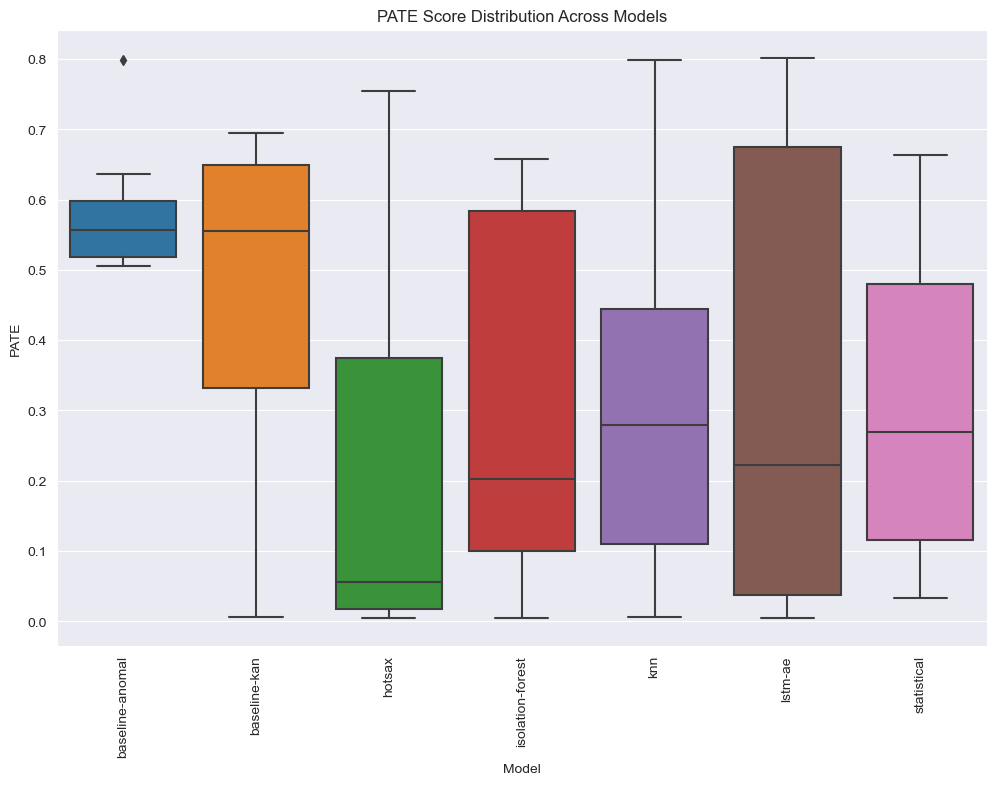

In [15]:
summary_stats = df.groupby('Model')['PATE'].describe()

print(summary_stats)

# Step 2: Visualizing the sensitivity of the PATE scores across models
plt.figure(figsize=(12, 8))

# Boxplot of PATE scores across different models
sns.boxplot(x='Model', y='PATE', data=df)
plt.xticks(rotation=90)
plt.title('PATE Score Distribution Across Models')
plt.show()

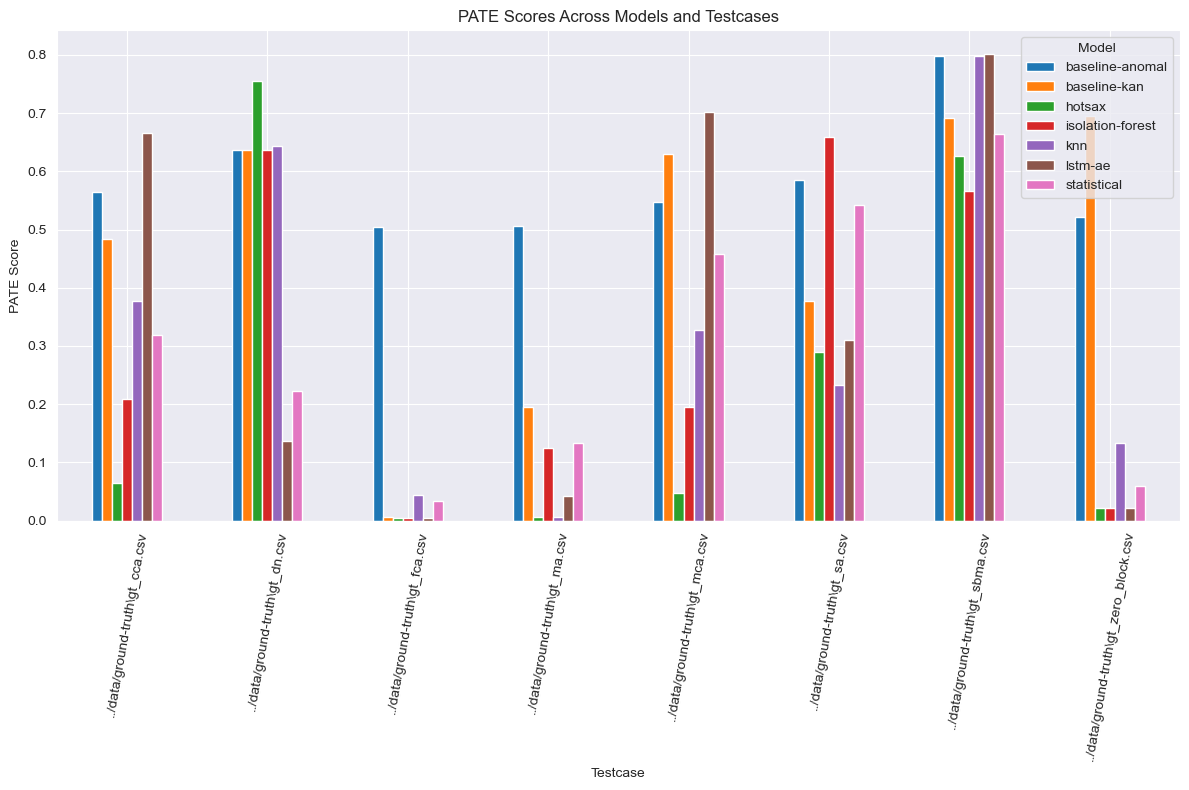

In [16]:
mean_pate = df.groupby(['Testcase', 'Model'])['PATE'].mean().unstack()

# Plotting the mean PATE scores
mean_pate.plot(kind='bar', figsize=(12, 8))
plt.ylabel('PATE Score')
plt.title('PATE Scores Across Models and Testcases')
plt.xticks(rotation=80)
plt.tight_layout()
plt.show()

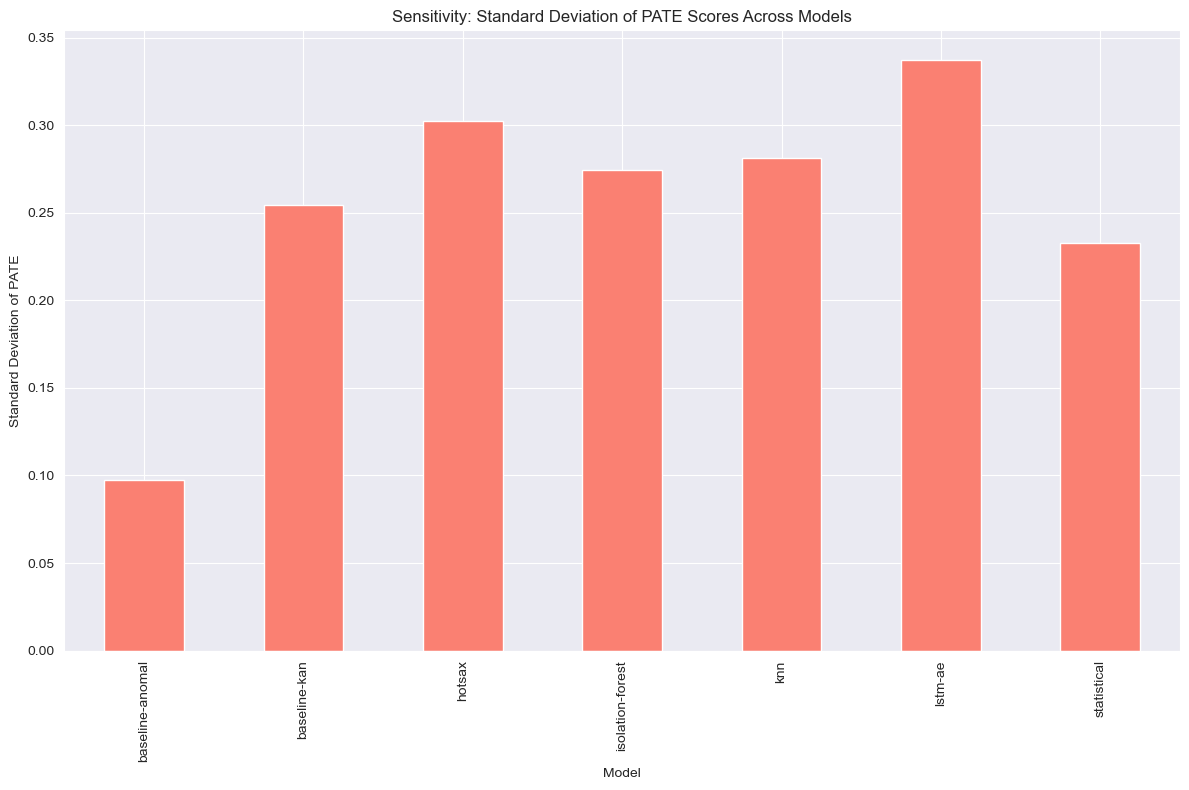

In [17]:
std_dev_pate = df.groupby('Model')['PATE'].std()

# Plot the standard deviation of PATE scores
std_dev_pate.plot(kind='bar', figsize=(12, 8), color='salmon')
plt.ylabel('Standard Deviation of PATE')
plt.title('Sensitivity: Standard Deviation of PATE Scores Across Models')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Sensititvity analysis for parameters of KNN
KNN has been tested on the same data set with 3 different sets of hyperparameters. The results are stored in the `sensitivity` folder. 
The three sets include:
- KNN with window_size=100, k=30
- KNN with window_size=200, k=60
- KNN with window_size=440, k=145

To find the best solution, we will evaluate the PATE scores for each of these models.

In [18]:
knn_results_dir = "sensitivity-analysis/"
knn_results = evaluate(knn_results_dir, gt)
knn_results.to_csv("knn_results.csv", index=False)

Evaluating ../data/ground-truth\gt_cca.csv


KeyboardInterrupt: 

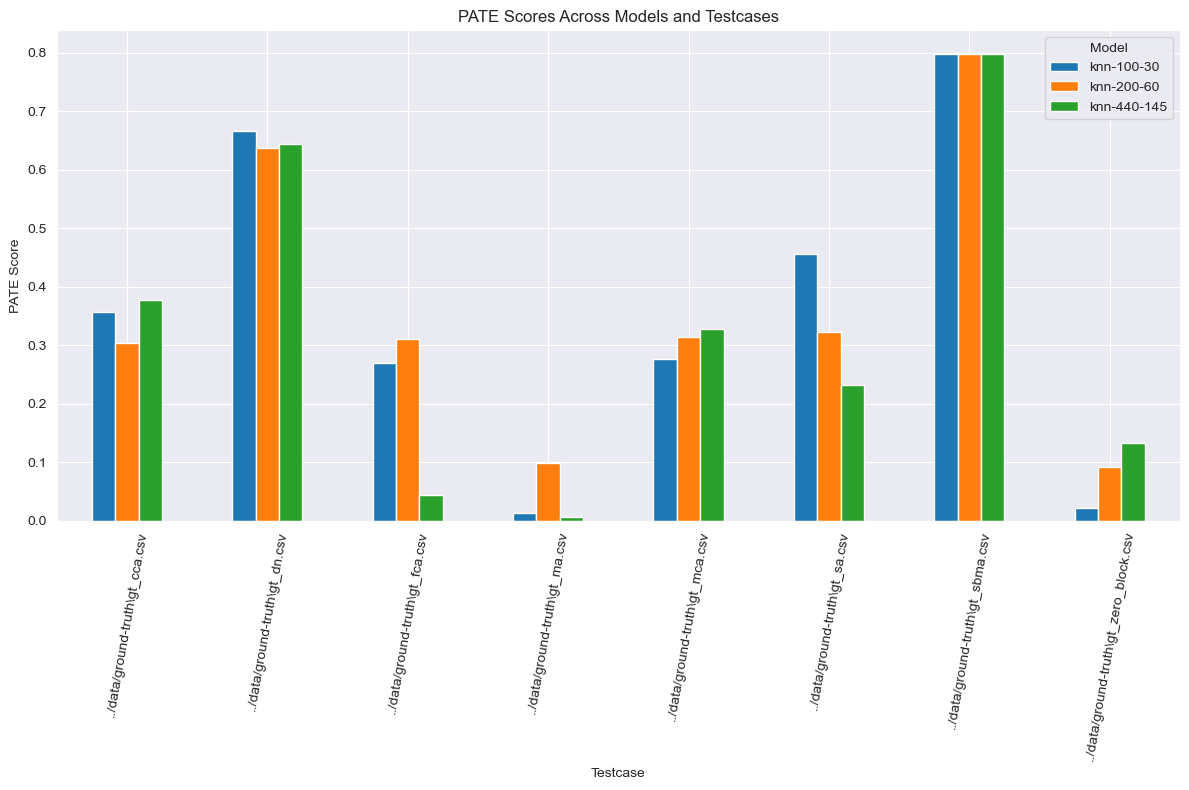

In [12]:
mean_pate = knn_results.groupby(['Testcase', 'Model'])['PATE'].mean().unstack()

# Plotting the mean PATE scores
mean_pate.plot(kind='bar', figsize=(12, 8))
plt.ylabel('PATE Score')
plt.title('PATE Scores Across KNN Configurations and Testcases')
plt.xticks(rotation=80)
plt.tight_layout()
plt.show()

             count      mean       std       min       25%       50%  \
Model                                                                  
knn-100-30     8.0  0.357243  0.278986  0.012782  0.207740  0.316936   
knn-200-60     8.0  0.359044  0.244472  0.091369  0.251788  0.312041   
knn-440-145    8.0  0.320137  0.281262  0.006287  0.110639  0.279632   

                  75%       max  
Model                            
knn-100-30   0.508529  0.798087  
knn-200-60   0.400473  0.798087  
knn-440-145  0.443709  0.798087  


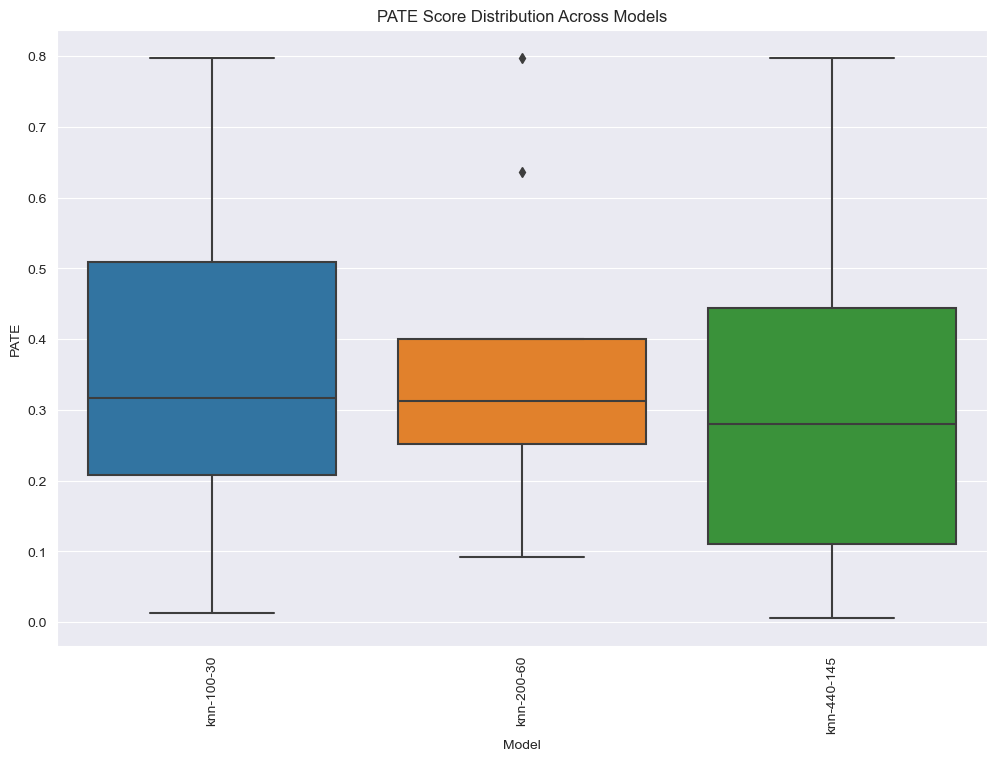

In [16]:
summary_stats = knn_results.groupby('Model')['PATE'].describe()

print(summary_stats)

# Step 2: Visualizing the sensitivity of the PATE scores across models
plt.figure(figsize=(12, 8))

# Boxplot of PATE scores across different models
sns.boxplot(x='Model', y='PATE', data=knn_results)
plt.xticks(rotation=90)
plt.title('PATE Score Distribution Across KNN')
plt.show()

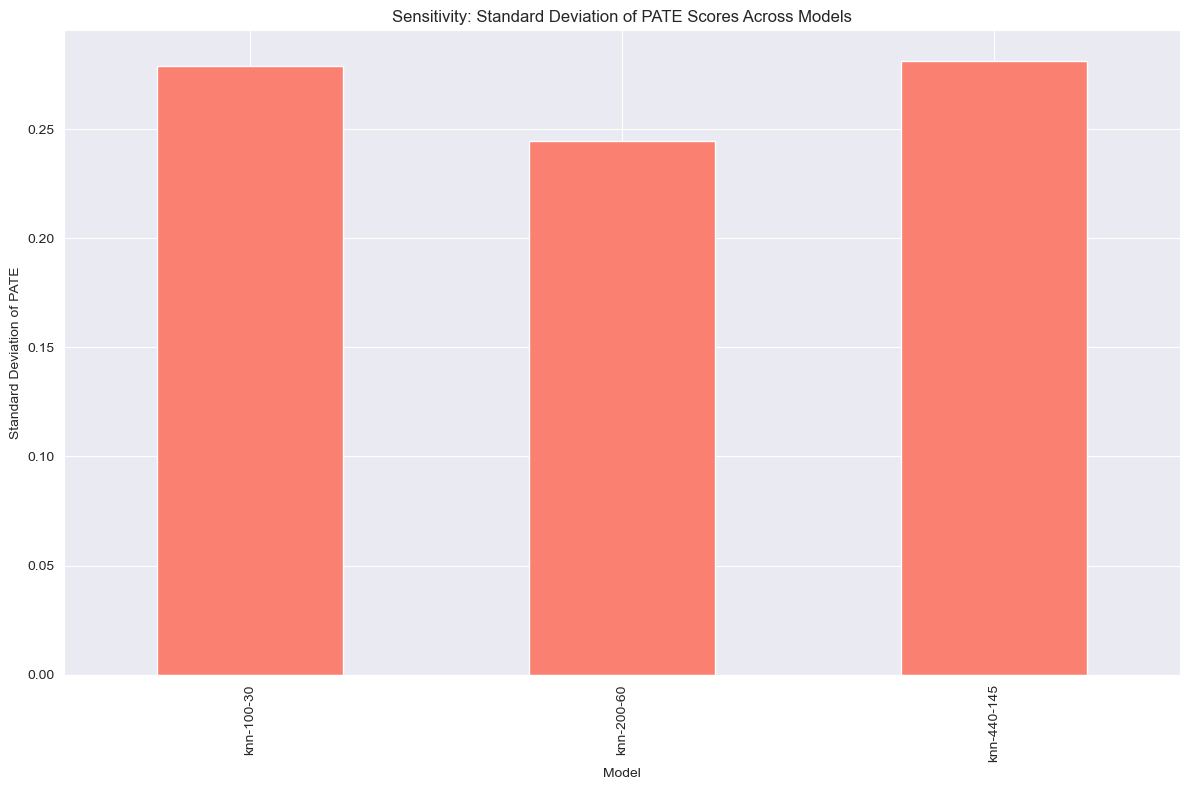

In [13]:
std_dev_pate = knn_results.groupby('Model')['PATE'].std()

# Plot the standard deviation of PATE scores
std_dev_pate.plot(kind='bar', figsize=(12, 8), color='salmon')
plt.ylabel('Standard Deviation of PATE')
plt.title('Sensitivity: Standard Deviation of PATE Scores Across KNN')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [23]:
# Evaluate only HotSAX, autoencoder, KNN and baselines
df = pd.read_csv("results.csv")
models = ['hotsax', 'lstm-ae', 'knn', 'baseline-anomal', 'baseline-kan']
df = df[df['Model'].isin(models)]

In [72]:
df_group = df.copy()
df_group = df_group.drop(columns=["Testcase"])
df_group = df_group.groupby(["Model"]).mean()
df_group

,PATE,PATE_F1
Model,,
baseline-anomal,0.583155,0.247966
baseline-kan,0.464118,0.253867
hotsax,0.227130,0.172148
knn,0.320137,0.085019
lstm-ae,0.335671,0.146152


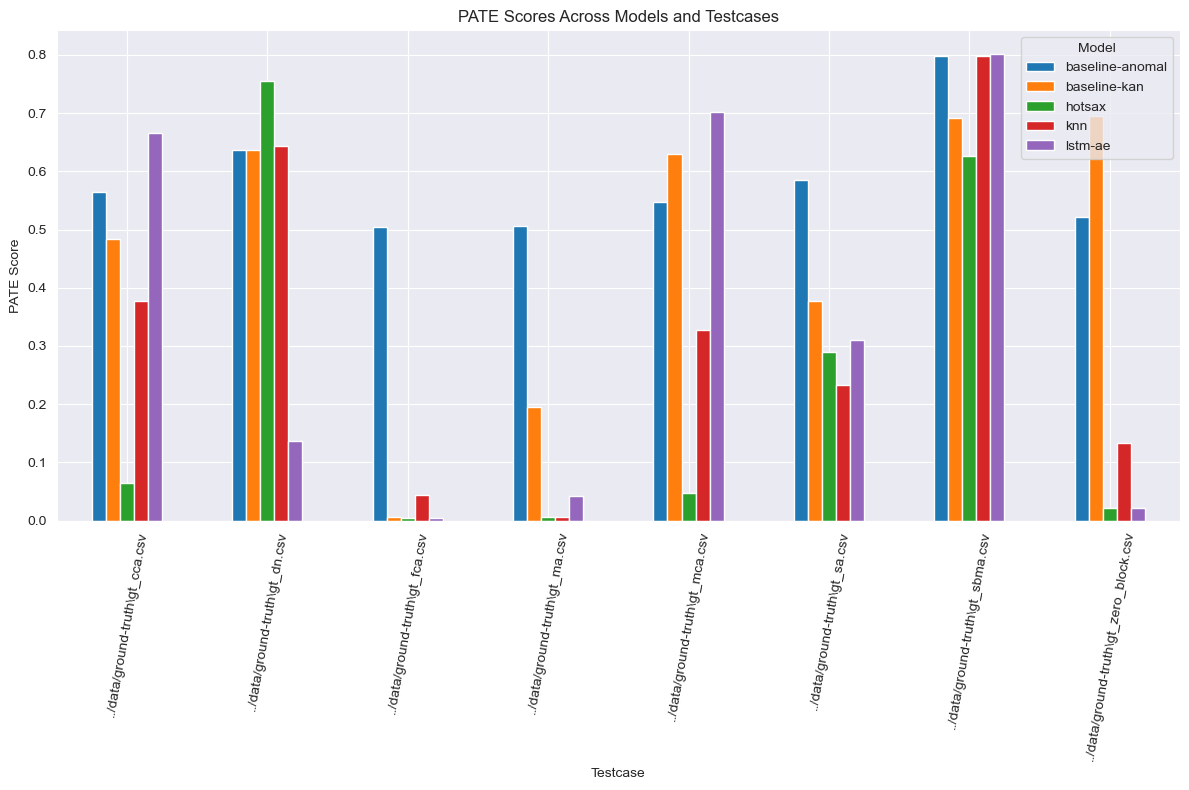

In [25]:
# Plotting the mean PATE scores
mean_pate.plot(kind='bar', figsize=(12, 8))
plt.ylabel('PATE Score')
plt.title('PATE Scores Across Models and Testcases')
plt.xticks(rotation=80)
plt.xlabel()
plt.tight_layout()
plt.show()

                 count      mean       std       min       25%       50%  \
Model                                                                      
baseline-anomal    8.0  0.583155  0.097380  0.505258  0.517700  0.556113   
baseline-kan       8.0  0.464118  0.254104  0.006474  0.331476  0.556060   
hotsax             8.0  0.227130  0.302609  0.005258  0.017700  0.056113   
knn                8.0  0.320137  0.281262  0.006287  0.110639  0.279632   
lstm-ae            8.0  0.335671  0.337196  0.005258  0.036851  0.223030   

                      75%       max  
Model                                
baseline-anomal  0.598397  0.798087  
baseline-kan     0.649893  0.695265  
hotsax           0.374386  0.754498  
knn              0.443709  0.798087  
lstm-ae          0.674921  0.802151  


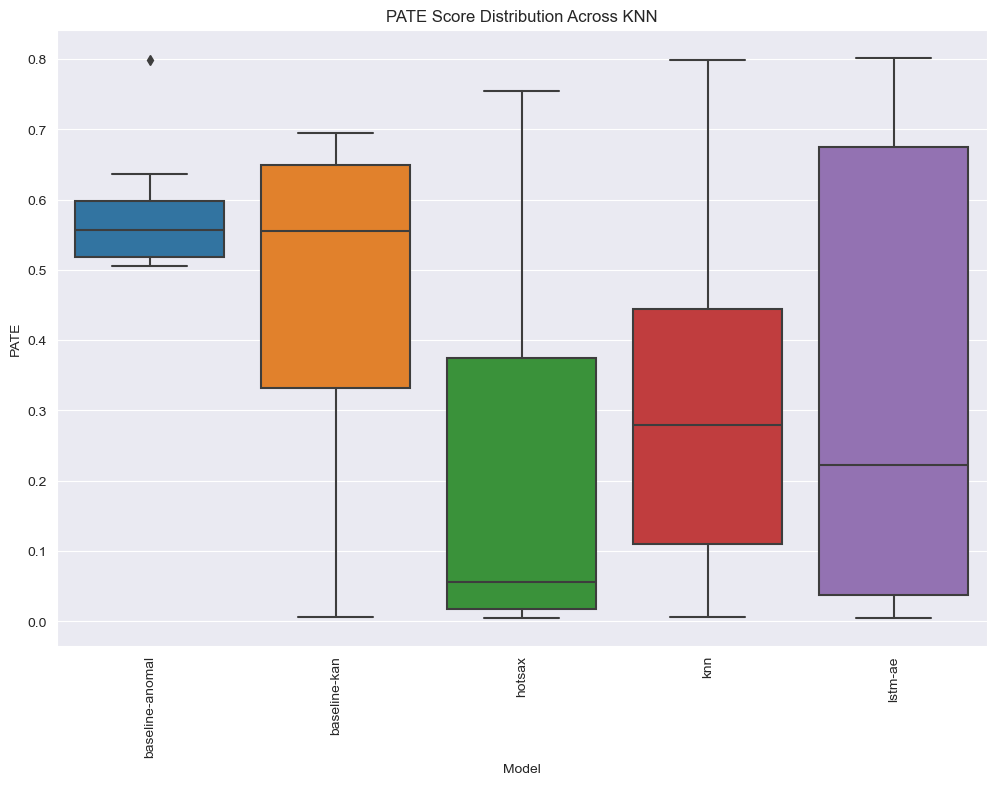

In [26]:
summary_stats = df.groupby('Model')['PATE'].describe()

print(summary_stats)

# Step 2: Visualizing the sensitivity of the PATE scores across models
plt.figure(figsize=(12, 8))

# Boxplot of PATE scores across different models
sns.boxplot(x='Model', y='PATE', data=df)
plt.xticks(rotation=90)
plt.title('PATE Score Distribution Across KNN')
plt.show()

In [68]:
def plot_anomaly_points(ts, gt, results, title):
    plt.figure(figsize=(12, 6))
    plt.plot(ts, label="Test Sequence")
    
    # Highlight points where gt == 1
    
    detected_points = [i for i, val in enumerate(results) if val == 1]
    plt.scatter(detected_points, [ts[i] for i in detected_points], color='yellow', label="Detected Anomalies")
    
    anomaly_points = [i for i, val in enumerate(gt) if val == 1]
    plt.scatter(anomaly_points, [ts[i] for i in anomaly_points], color='red', label="True Anomalies")
    
    true_points = [i for i, val in enumerate(results) if val == 1 and gt[i] == 1]
    plt.scatter(true_points, [ts[i] for i in true_points], color='green', label="True Detected Anomalies")
   
    
    plt.title(title)
    plt.legend()
    plt.show()

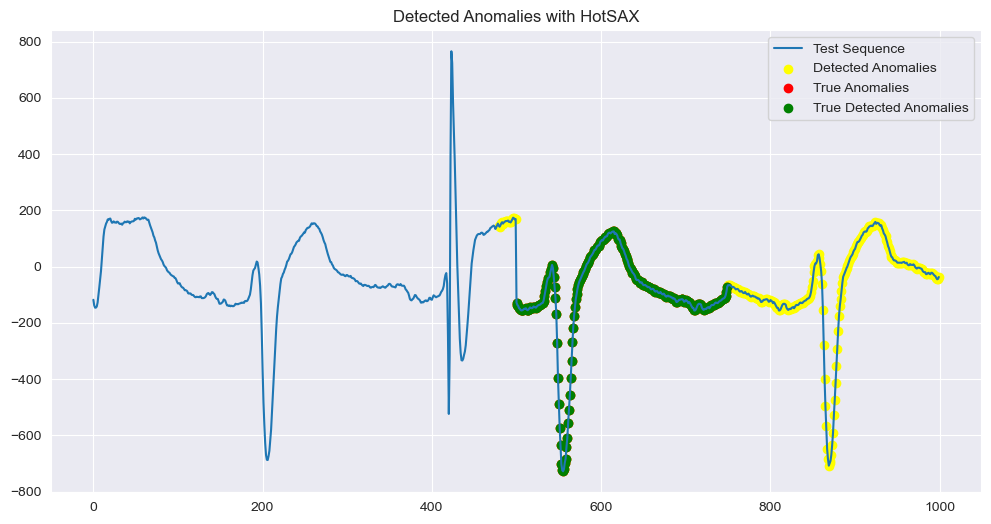

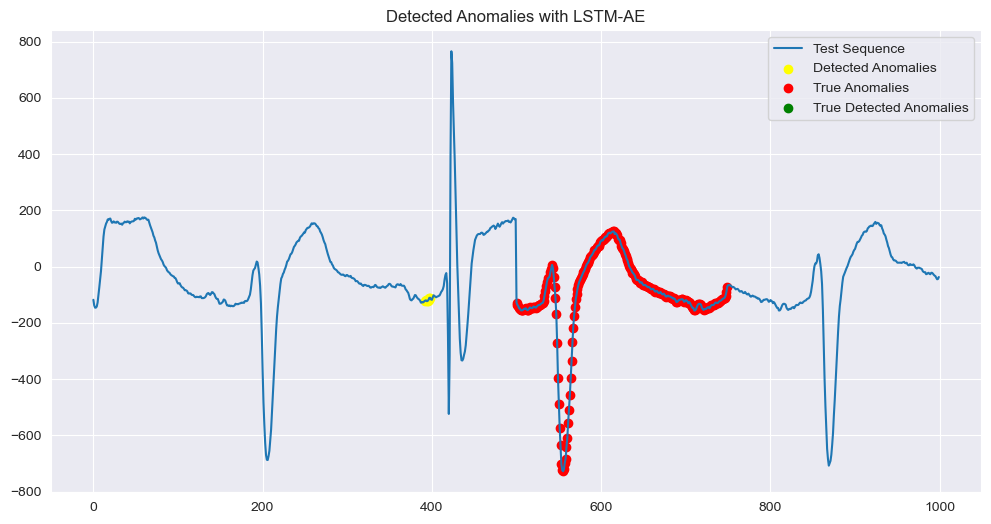

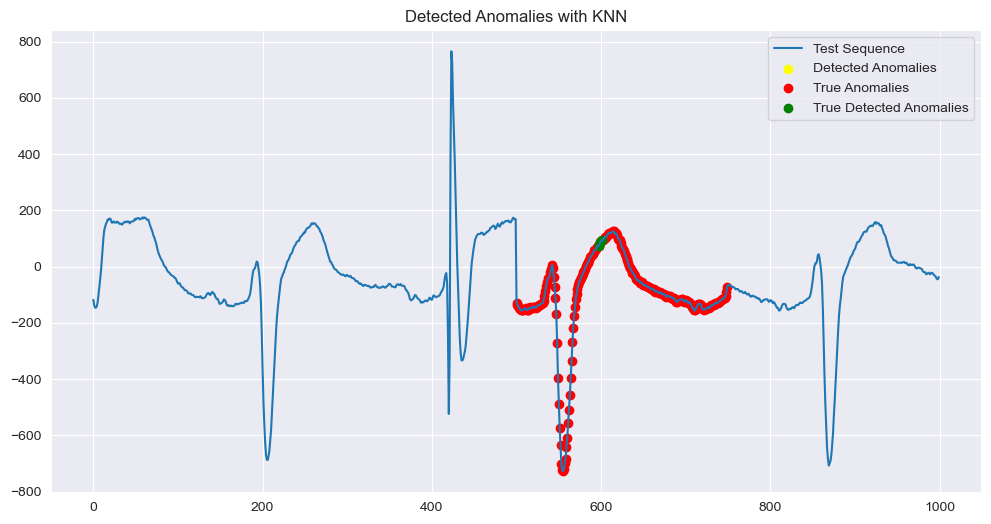

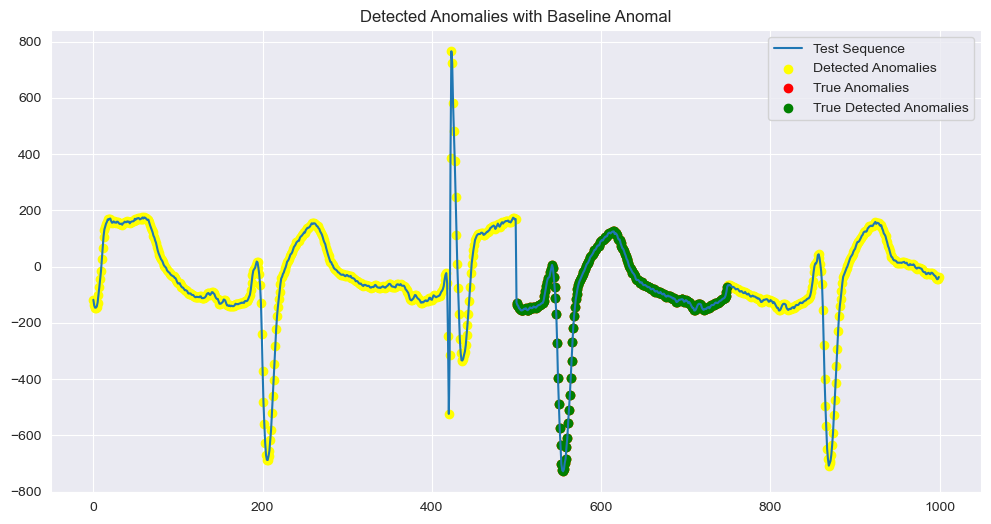

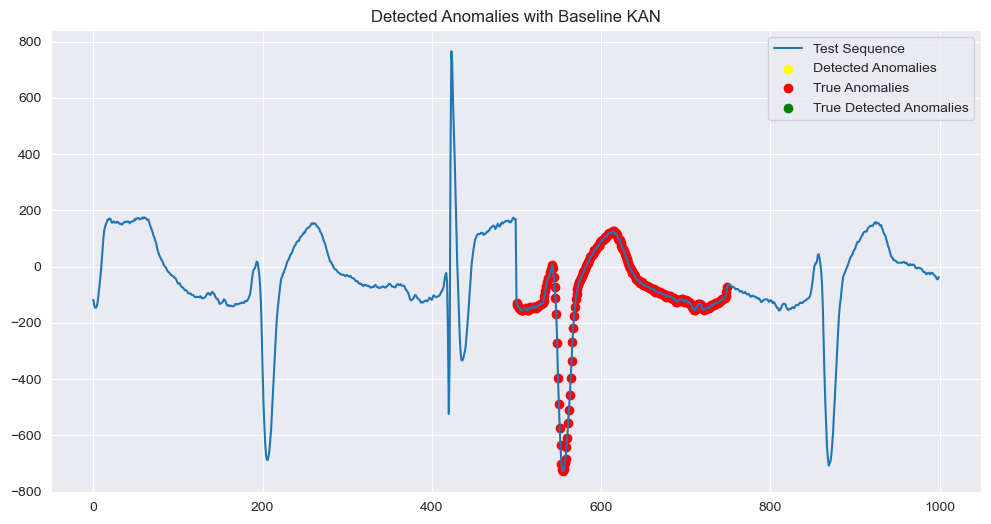

In [69]:
# plot single test example
testcase = "X_dn.csv"
gt = "gt_dn.csv"
testcase_file = pd.read_csv("../data/generated-tests/" + testcase, header=None)
gt_file = pd.read_csv("../data/ground-truth/" + gt, header=None)
results_hotsax = pd.read_csv("../data/model-results/hotsax/" + testcase, header=None)
results_lstm = pd.read_csv("../data/model-results/lstm-ae/" + testcase, header=None)
results_knn = pd.read_csv("../data/model-results/knn/" + testcase, header=None)
results_baseline = pd.read_csv("../data/model-results/baseline-anomal/" + testcase, header=None)
results_baseline_kan = pd.read_csv("../data/model-results/baseline-kan/" + testcase, header=None)


plot_anomaly_points(testcase_file[0], gt_file[0], results_hotsax[0], "Detected Anomalies with HotSAX")
plot_anomaly_points(testcase_file[0], gt_file[0], results_lstm[0], "Detected Anomalies with LSTM-AE")
plot_anomaly_points(testcase_file[0], gt_file[0], results_knn[0], "Detected Anomalies with KNN")
plot_anomaly_points(testcase_file[0], gt_file[0], results_baseline[0], "Detected Anomalies with Baseline Anomal")
plot_anomaly_points(testcase_file[0], gt_file[0], results_baseline_kan[0], "Detected Anomalies with Baseline KAN")